# 1. Importando bibliotecas

In [118]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
# para encoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
# para calculo del vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# para balanceo de clases
from imblearn.over_sampling import SMOTE
# para modelado
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# para validacion
from sklearn.model_selection import cross_val_score ,train_test_split, StratifiedKFold
from imblearn.pipeline import Pipeline
# para evaluar metricas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, roc_auc_score
from sklearn.metrics import classification_report
# para optimización de hiperparametros
from sklearn.model_selection import GridSearchCV
# para calibrado
from sklearn.calibration import CalibratedClassifierCV

# 2. Carga de datos

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
df = pd.read_csv('/content/drive/MyDrive/ONE/HACKATHON/DATASET/DF_FEATURE_ENGINNERING/dataset_feature_enginnering_final.csv')

In [121]:
df.sample(5)

,antiguedad,plan,metodo_pago,tipo_contrato,frecuencia_uso,cambios_plan,facturas_impagas,tickets_soporte,canal_adquisicion,friccion_del_servicio,engagement_score,valor_plan_num,ratio_valor_uso,riesgo_financiero,cliente_problematico,early_churn_risk,premium_mensual,churn
3594,28,basico,tarjeta_credito,anual,27,1,3,5,call_center,0.178571,0.670000,4.99,0.178214,14.97,0,0,0,0
1120,26,premium,transferencia_bancaria,mensual,20,1,1,10,web,0.476190,0.571667,14.99,0.713810,14.99,0,0,1,0
868,45,basico,transferencia_bancaria,anual,15,1,2,6,call_center,0.375000,0.552500,4.99,0.311875,9.98,0,0,0,0
2472,29,estandar,efectivo,mensual,7,1,1,2,web,0.250000,0.405833,9.99,1.248750,9.99,0,0,0,0
1226,2,estandar,tarjeta_credito,mensual,19,3,2,4,call_center,0.200000,0.378333,9.99,0.499500,19.98,0,1,0,1


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   antiguedad             4251 non-null   int64  
 1   plan                   4251 non-null   object 
 2   metodo_pago            4251 non-null   object 
 3   tipo_contrato          4251 non-null   object 
 4   frecuencia_uso         4251 non-null   int64  
 5   cambios_plan           4251 non-null   int64  
 6   facturas_impagas       4251 non-null   int64  
 7   tickets_soporte        4251 non-null   int64  
 8   canal_adquisicion      4251 non-null   object 
 9   friccion_del_servicio  4251 non-null   float64
 10  engagement_score       4251 non-null   float64
 11  valor_plan_num         4251 non-null   float64
 12  ratio_valor_uso        4251 non-null   float64
 13  riesgo_financiero      4251 non-null   float64
 14  cliente_problematico   4251 non-null   int64  
 15  earl

In [123]:
# Proporcion de churn

df['churn'].value_counts(normalize=True)

,proportion
churn,
0,0.746177
1,0.253823


# 3. Selección de variables explicativas y variable objetivo

In [124]:
X = df.drop(columns='churn')
y = df['churn']

columnas = X.columns

# 4. Encoding

In [125]:
preprocesador = make_column_transformer((OneHotEncoder(drop='first'),
                                         ['plan', 'metodo_pago', 'tipo_contrato', 'canal_adquisicion']),
                                        remainder='passthrough',
                                        sparse_threshold = 0)

X = preprocesador.fit_transform(X)

df_codificado = pd.DataFrame(X, columns= preprocesador.get_feature_names_out(columnas))

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

df_codificado['churn'] = y

print(df_codificado)
print(df_codificado.info())

      onehotencoder__plan_estandar  onehotencoder__plan_premium  \
0                              1.0                          0.0   
1                              1.0                          0.0   
2                              0.0                          1.0   
3                              1.0                          0.0   
4                              1.0                          0.0   
...                            ...                          ...   
4246                           0.0                          1.0   
4247                           1.0                          0.0   
4248                           0.0                          0.0   
4249                           1.0                          0.0   
4250                           1.0                          0.0   

      onehotencoder__metodo_pago_tarjeta_credito  \
0                                            0.0   
1                                            0.0   
2                                      

# 5. Analisis de correlación y multicolinearidad

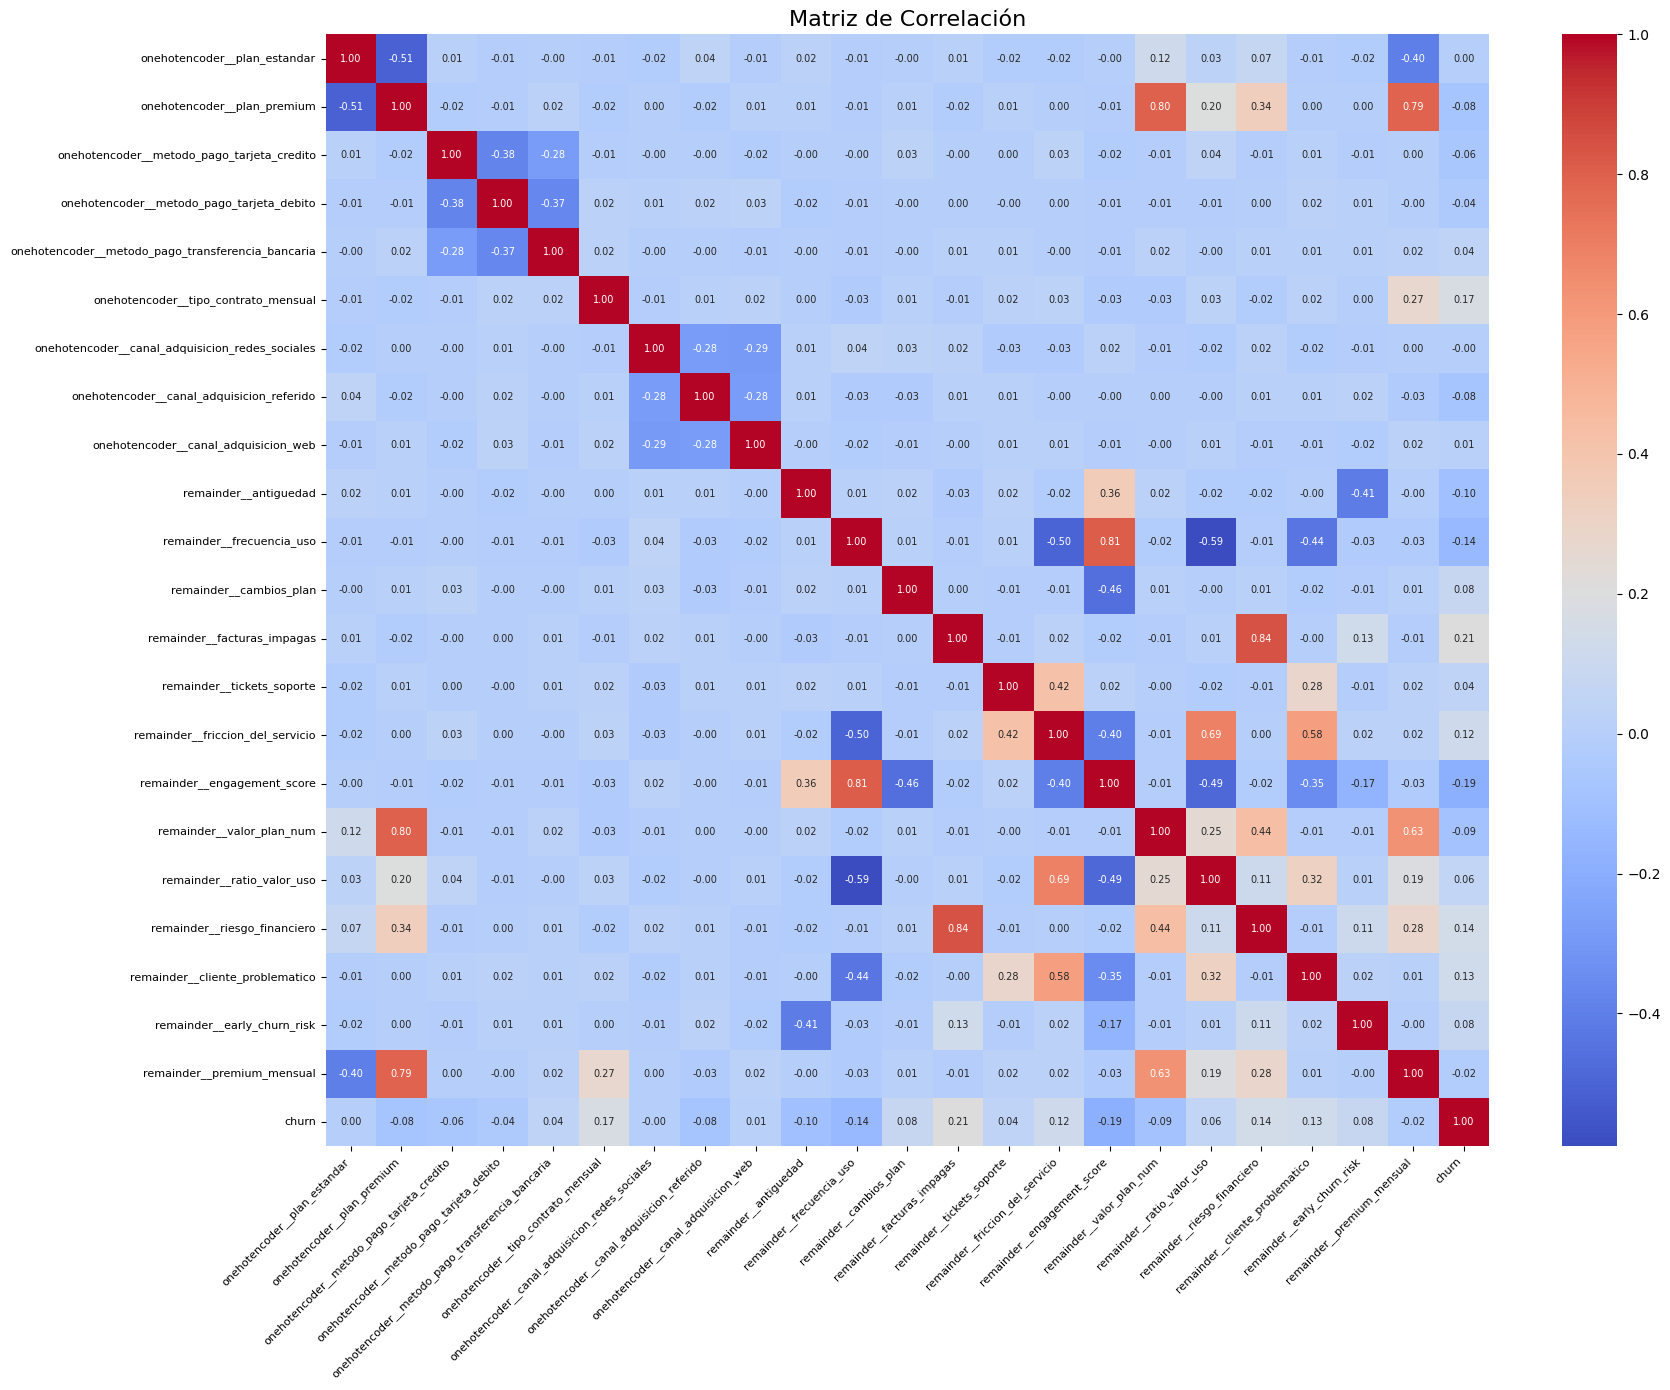

/tmp/ipython-input-408209219.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


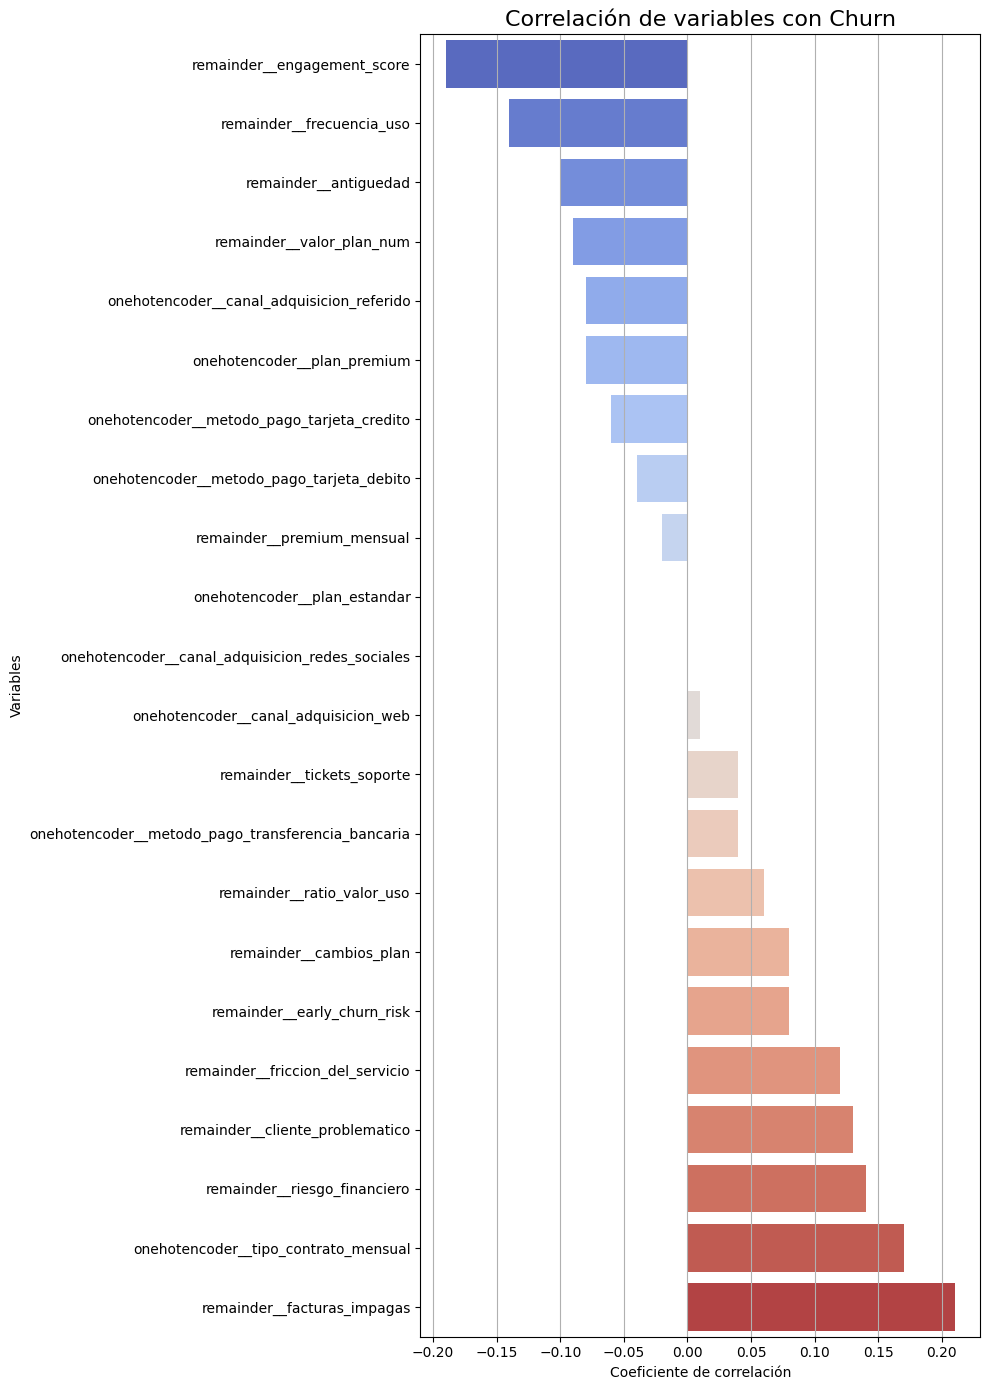

In [126]:
# Analisis de correlación y multicolinearidad

corr = df_codificado.corr().round(2)

plt.figure(figsize=(18, 14))  # definimos el tamaño de figura
sns.heatmap(corr,
            annot=True,         # mostramos los valores de correlación dentro de cada celda
            fmt=".2f",
            cmap='coolwarm',    # paleta de colores
            annot_kws={"size": 7})  # reducimos el tamaño del texto dentro de las celdas

plt.xticks(rotation=45, ha='right', fontsize=8)  # rotamos y achicamos los ticks del eje x
plt.yticks(fontsize=8)                           # tamaño de fuente de los ticks del eje y
plt.title("Matriz de Correlación", fontsize=16)
plt.tight_layout()
plt.show()

# Visualizando mejor las correlaciones con la variable Churn

corr = corr.drop(index='churn').sort_values(by='churn', ascending=True)

plt.figure(figsize=(10, 14))
sns.barplot(
    x='churn',
    y=corr.index,
    data=corr,
    palette='coolwarm'
)
plt.title("Correlación de variables con Churn", fontsize=16)
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variables")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# 6. Analisis VIF

In [127]:
# variables explicativas
X = df.drop(columns='churn')

# agregar constante
X_const = add_constant(X)

In [128]:
# calcular vif

# Usar el DataFrame codificado para calcular el VIF
X_vif = df_codificado.drop(columns='churn')

# agregar constante
X_vif_const = add_constant(X_vif)

vif_df = pd.DataFrame()
vif_df['feature'] = X_vif_const.columns
vif_df['vif'] = [
    variance_inflation_factor(X_vif_const.values, i)
    for i in range(X_vif_const.shape[1])
]

print(vif_df)

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                              feature        vif
0                                               const   0.000000
1                        onehotencoder__plan_estandar        inf
2                         onehotencoder__plan_premium        inf
3          onehotencoder__metodo_pago_tarjeta_credito   1.552274
4           onehotencoder__metodo_pago_tarjeta_debito   1.658554
5   onehotencoder__metodo_pago_transferencia_bancaria   1.542994
6                onehotencoder__tipo_contrato_mensual   1.287994
7     onehotencoder__canal_adquisicion_redes_sociales   1.297978
8           onehotencoder__canal_adquisicion_referido   1.296366
9                onehotencoder__canal_adquisicion_web   1.297256
10                              remainder__antiguedad        inf
11                          remainder__frecuencia_uso        inf
12                            remainder__cambios_plan        inf
13                        remainder__facturas_impagas   8.287030
14                       

#### a) Al hacer el analisis de multicolinearidad, asi como el calculo del VIF, se observo que las features 'engagement_score', 'valor_plan_num' y 'riesgo_financiero' son las mas propensas a sesgar el modelo.

In [129]:
columnas_a_eliminar = ['remainder__engagement_score', 'remainder__valor_plan_num', 'remainder__riesgo_financiero']

In [130]:
X_vif_const = X_vif_const.drop(columns=columnas_a_eliminar)

In [131]:
# Analizando nuevamente el VIF sin las columnas mas 'problematicas'
vif_df = pd.DataFrame()
vif_df['feature'] = X_vif_const.columns
vif_df['vif'] = [
    variance_inflation_factor(X_vif_const.values, i)
    for i in range(X_vif_const.shape[1])
]

print(vif_df)

                                              feature        vif
0                                               const  26.887523
1                        onehotencoder__plan_estandar   1.453716
2                         onehotencoder__plan_premium   3.723671
3          onehotencoder__metodo_pago_tarjeta_credito   1.551551
4           onehotencoder__metodo_pago_tarjeta_debito   1.657355
5   onehotencoder__metodo_pago_transferencia_bancaria   1.542540
6                onehotencoder__tipo_contrato_mensual   1.287885
7     onehotencoder__canal_adquisicion_redes_sociales   1.297598
8           onehotencoder__canal_adquisicion_referido   1.296241
9                onehotencoder__canal_adquisicion_web   1.297032
10                              remainder__antiguedad   1.200901
11                          remainder__frecuencia_uso   1.793841
12                            remainder__cambios_plan   1.003602
13                        remainder__facturas_impagas   1.020173
14                       

### Todas las features muestran un VIF inferior a 5, indicando que no hay una multicolinearidad fuerte.

In [132]:
# Eliminamos las features 'problematicas' del df

df_codificado = df_codificado.drop(columns=columnas_a_eliminar)

df_codificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 20 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehotencoder__plan_estandar                       4251 non-null   float64
 1   onehotencoder__plan_premium                        4251 non-null   float64
 2   onehotencoder__metodo_pago_tarjeta_credito         4251 non-null   float64
 3   onehotencoder__metodo_pago_tarjeta_debito          4251 non-null   float64
 4   onehotencoder__metodo_pago_transferencia_bancaria  4251 non-null   float64
 5   onehotencoder__tipo_contrato_mensual               4251 non-null   float64
 6   onehotencoder__canal_adquisicion_redes_sociales    4251 non-null   float64
 7   onehotencoder__canal_adquisicion_referido          4251 non-null   float64
 8   onehotencoder__canal_adquisicion_web               4251 non-null   float64
 9   remainde

In [133]:
# Selección de las variables explicativas y objetivo

X = df_codificado.drop(columns='churn')
y = df_codificado['churn']

# 7. Modelo de Regresión Logistica

In [134]:
# Balanceo de clases y normalización
oversample = SMOTE(random_state=82)
normalizacion = MinMaxScaler()

In [135]:
# Separación de datos

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=82, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=82)

In [136]:
# Balanceo de clases

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [137]:
# Normalización

X_train_normalize = normalizacion.fit_transform(X_train_smote)
X_test_normalize = normalizacion.transform(X_test)
X_val_normalize = normalizacion.transform(X_val)

In [138]:
# Creando el modelo

modelo_lr = LogisticRegression(max_iter=1000, random_state=82)

modelo_lr.fit(X_train_normalize, y_train_smote)

LogisticRegression(max_iter=1000, random_state=82)

In [139]:
# Validación cruzada
def intervalo_confianza(validacion, nombreModelo):
  promedio = validacion.mean()
  std = validacion.std()
  return f'intervalo de confianza, modelo {nombreModelo}: [{promedio - (2*std)}, {min((promedio + (2*std)), 1)}]'

stratkf = StratifiedKFold(n_splits=5, random_state=82, shuffle=True)

pipeline = Pipeline([('oversample', SMOTE()), ('forest', modelo_lr)])
validacion = cross_val_score(pipeline, X_temp, y_temp, cv=stratkf, scoring='recall')
print(intervalo_confianza(validacion, 'lr'))

intervalo de confianza, modelo lr: [0.5704002798796775, 0.7506374940146632]


In [140]:
print(modelo_lr.score(X_train_normalize, y_train_smote))
print(modelo_lr.score(X_test_normalize, y_test))

0.6992610837438423
0.6827262044653349


In [141]:
# Metricas de evaluación

def calcularMetricas(y_true ,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  metricas = {'Accuracy': round(accuracy, 4),
              'F1': round(f1, 4),
              'Recall': round(recall, 4),
              'Precision': round(precision, 4)}
  return metricas

  # Matriz de confusión
def matriz_confusion(y_true, y_pred):
  matriz = confusion_matrix(y_true, y_pred)
  visualizer = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['No desertó', 'Desertó'])
  return visualizer.plot()

{'Accuracy': 0.6779, 'F1': 0.5101, 'Recall': 0.659, 'Precision': 0.4161}


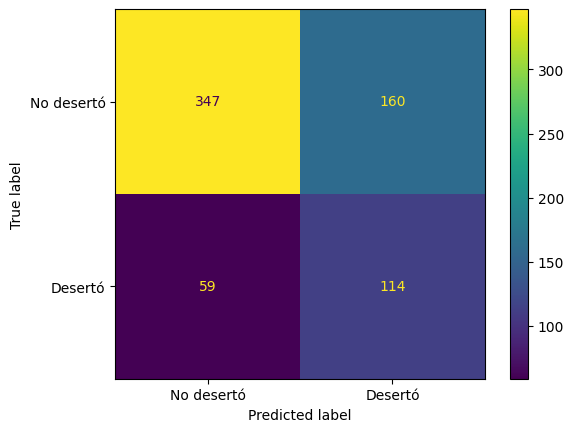

In [142]:
y_pred = modelo_lr.predict(X_val_normalize)
print(calcularMetricas(y_val ,y_pred))

visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Feature importances

In [143]:
# Convertimos X_train_smote y X_val a df para seleccionar las features
X_train_norm_df = pd.DataFrame(X_train_normalize, columns=df_codificado.drop(columns='churn', axis=1).columns)
X_val_norm_df = pd.DataFrame(X_val_normalize, columns=df_codificado.drop(columns='churn', axis=1).columns)

importancias_lr = pd.DataFrame({
    'Features': X_train_norm_df.columns,
    'Coeficiente': modelo_lr.coef_[0],
    'Importancia': np.abs(modelo_lr.coef_[0])
}).sort_values('Importancia', ascending=False)

print(importancias_lr)


importancias_lr['Importancia_%'] = (
    importancias_lr['Importancia'] / importancias_lr['Importancia'].sum() * 100
).round(2)

importancias_lr = importancias_lr.sort_values('Importancia_%', ascending=False)


print(importancias_lr)

model_features = LogisticRegression(max_iter=1000, random_state=82)

resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

ct_features = [i for i in range(1, 19)]
resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

for i in ct_features:
    selected_features = importancias_lr['Features'].values[:i]
    X_train_sel = X_train_norm_df[selected_features]
    X_val_sel = X_val_norm_df[selected_features]

    model_features.fit(X_train_sel, y_train_smote)
    y_previsto = model_features.predict(X_val_sel)

    metricas = calcularMetricas(y_val, y_previsto)
    resultados[i] = list(metricas.values())

print(resultados)


                                             Features  Coeficiente  \
12                        remainder__facturas_impagas     2.043430   
9                               remainder__antiguedad    -1.437843   
5                onehotencoder__tipo_contrato_mensual     1.177782   
10                          remainder__frecuencia_uso    -0.890797   
11                            remainder__cambios_plan     0.830432   
2          onehotencoder__metodo_pago_tarjeta_credito    -0.813869   
7           onehotencoder__canal_adquisicion_referido    -0.800314   
1                         onehotencoder__plan_premium    -0.791913   
16                    remainder__cliente_problematico     0.650784   
3           onehotencoder__metodo_pago_tarjeta_debito    -0.559139   
8                onehotencoder__canal_adquisicion_web    -0.436869   
13                         remainder__tickets_soporte    -0.421128   
6     onehotencoder__canal_adquisicion_redes_sociales    -0.396091   
0                   

### En este caso, se optara por seleccionar las **4 mejores features**

### Segmentando con las mejores features

In [144]:
lr_features = importancias_lr['Features'].values[:4]

X_selected_features = df_codificado[lr_features]

print(lr_features)

['remainder__facturas_impagas' 'remainder__antiguedad'
 'onehotencoder__tipo_contrato_mensual' 'remainder__frecuencia_uso']


In [145]:
# segmentando nuevamente los datos con las mejores features
X_temp, X_test, y_temp, y_test = train_test_split(X_selected_features, y, stratify=y, random_state=82, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=82, test_size=0.2)

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)


X_train_normalize = normalizacion.fit_transform(X_train_smote)
X_val_normalize = normalizacion.transform(X_val)
X_test_normalize = normalizacion.transform(X_test)

## Optimización de hiperparametros

{'C': 0.01, 'class_weight': {0: 1, 1: 1.2}, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
{'Accuracy': 0.4309, 'F1': 0.4632, 'Recall': 0.9653, 'Precision': 0.3047}


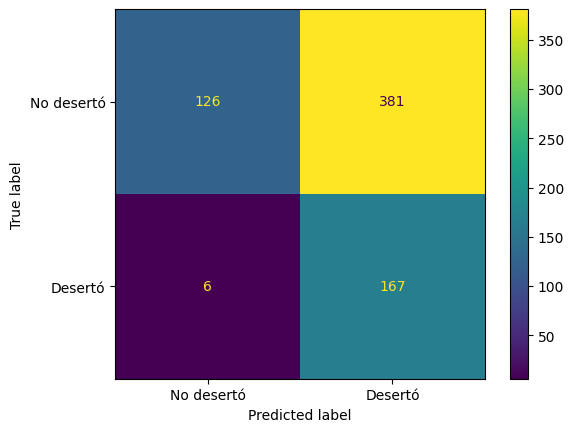

In [146]:
# Grilla de hiperparametros
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, {0:1, 1:1.2}, {0:1, 1:1.5}],
    'max_iter': [200, 500, 1000]
}


grid_lr = GridSearchCV(LogisticRegression(random_state=82), param_grid_lr, cv=stratkf, scoring='recall')
grid_lr.fit(X_train_normalize, y_train_smote)

print(grid_lr.best_params_)

# Eligiendo el mejor modelo
best_lr = grid_lr.best_estimator_

best_lr.fit(X_train_normalize, y_train_smote)

# Analisis de metricas
y_pred = best_lr.predict(X_val_normalize)
print(calcularMetricas(y_val, y_pred))
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Curva ROC y PR

0.6997069922814698


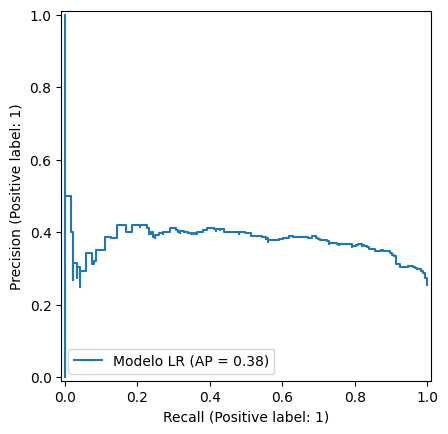

In [147]:
y_pred = best_lr.predict_proba(X_val_normalize)

roc_auc = roc_auc_score(y_val, y_pred[:, 1])
print(roc_auc)
PrecisionRecallDisplay.from_predictions(y_val, y_pred[:, 1], name='Modelo LR')
plt.show()

## Eligiendo el umbral

In [148]:
y_proba = best_lr.predict_proba(X_test_normalize)[:, 1]

In [149]:
y_proba.min(), y_proba.max()

(np.float64(0.4106977630137952), np.float64(0.6648460572989785))

In [150]:
thresholds = np.arange(0.4, 0.66, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.40,0.253819,1.000000,0.404873,851
1,0.41,0.253819,1.000000,0.404873,851
2,0.42,0.256228,1.000000,0.407932,843
3,0.43,0.258993,1.000000,0.411429,834
4,0.44,0.260870,1.000000,0.413793,828
5,0.45,0.262136,1.000000,0.415385,824
6,0.46,0.270338,1.000000,0.425616,799
7,0.47,0.276569,1.000000,0.433300,781
8,0.48,0.280472,0.990741,0.437181,763
9,0.49,0.290366,0.990741,0.449108,737


### **Umbral optimo**: 0.54

## Calibrando las probabilidades

In [151]:
lr_calibrado = CalibratedClassifierCV(
    estimator=best_lr,
    method="sigmoid",
    cv=5
)

In [152]:
lr_calibrado.fit(X_train_normalize, y_train_smote)

CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(C=0.01,
                                                    class_weight={0: 1, 1: 1.2},
                                                    max_iter=200, penalty='l1',
                                                    random_state=82,
                                                    solver='liblinear'))

In [153]:
y_proba_cal = lr_calibrado.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [154]:
y_proba_cal.min(), y_proba_cal.max()

(np.float64(0.019385209350992437), np.float64(0.9946841693398618))

In [155]:
thresholds = np.linspace(y_proba_cal.min(), y_proba_cal.max(), 20)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.019385,0.253819,1.000000,0.404873,851
1,0.070717,0.289694,0.962963,0.445396,718
2,0.122048,0.296081,0.944444,0.450829,689
3,0.173380,0.308756,0.930556,0.463668,651
4,0.224711,0.321070,0.888889,0.471744,598
5,0.276043,0.321561,0.800926,0.458886,538
6,0.327374,0.334755,0.726852,0.458394,469
7,0.378706,0.367292,0.634259,0.465195,373
8,0.430037,0.387681,0.495370,0.434959,276
9,0.481369,0.392713,0.449074,0.419006,247


In [156]:
thresholds = np.arange(0.2, 0.4, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.20,0.314286,0.916667,0.468085,630
1,0.21,0.315359,0.893519,0.466184,612
2,0.22,0.320534,0.888889,0.471166,599
3,0.23,0.322581,0.879630,0.472050,589
4,0.24,0.323478,0.861111,0.470291,575
5,0.25,0.322751,0.847222,0.467433,567
6,0.26,0.322878,0.810185,0.461741,542
7,0.27,0.321561,0.800926,0.458886,538
8,0.28,0.318868,0.782407,0.453083,530
9,0.29,0.320611,0.777778,0.454054,524


### **Umbral optimo**: 0.24

## Curva ROC y PR Post-Calibración

0.6895942356146891


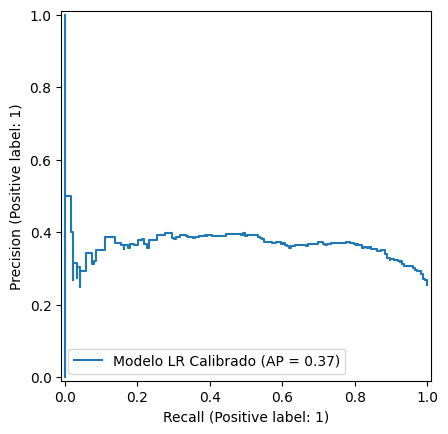

In [157]:
y_pred = lr_calibrado.predict_proba(X_val_normalize)
roc_auc = roc_auc_score(y_val, y_pred[:, 1])
print(roc_auc)

PrecisionRecallDisplay.from_predictions(y_val, y_pred[:, 1], name='Modelo LR Calibrado')
plt.show()

## Nombre de los modelos:

Modelo sin calibrar: **best_lr**

Modelo calibrado: **lr_calibrado**